In [7]:
!pip install -q qiskit qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import DiagonalGate, Initialize
from qiskit.quantum_info import Statevector
from qiskit.circuit import QuantumRegister, QuantumCircuit

# --- 1. Load and rename the dataset ---
df = pd.read_excel('EEG data.xlsx')
df = df.rename(columns={
    'коды': 'Subject_Code',
    'группа': 'Group',
    'нет': 'Electrode_Pair',
    'отведения': 'Brain_Region',
    'ритм': 'EEG_Band',
    'observ': 'Mean_Obs_Amplitude',
    'imagin': 'Mean_Imag_Amplitude',
    'execut': 'Mean_Exec_Amplitude',
    'together': 'Mean_Total_Amplitude',
    'observ.1': 'Z_Obs_Amplitude',
    'imagin.1': 'Z_Imag_Amplitude',
    'execut.1': 'Z_Exec_Amplitude',
    'together.1': 'Z_Total_Amplitude'
})

# --- 2. Map 'Group' to anxiety labels (0 = control, 1 = patient/anxiety) ---
df['Anxiety_Level'] = df['Group'].map({'control': 0, 'patients': 1})

# --- 3. Pivot so each subject is one feature vector ---
features = [
    'Mean_Obs_Amplitude', 'Mean_Imag_Amplitude',
    'Mean_Exec_Amplitude', 'Mean_Total_Amplitude',
    'Z_Obs_Amplitude', 'Z_Imag_Amplitude',
    'Z_Exec_Amplitude', 'Z_Total_Amplitude'
]
pivot = df.pivot_table(index='Subject_Code', columns='EEG_Band', values=features)
# Flatten MultiIndex columns
pivot.columns = [f"{band}_{feat}" for feat in pivot.columns.levels[1] for band in pivot.columns.levels[0]]
X = pivot.values
y = df.drop_duplicates('Subject_Code').set_index('Subject_Code')['Anxiety_Level'].loc[pivot.index].values


from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors
# Assuming 'X' is your feature matrix with missing values
X_imputed = imputer.fit_transform(X)

# --- 4. Dimensionality reduction & normalization ---
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_imputed)
X_norm = normalize(X_pca)

# --- 5. Train-test split ---
# X_train, X_test, y_train, y_test = train_test_split(
#     X_norm, y, test_size=0.2, random_state=42
# )

# 1. Separate data by class:
class_A_indices = np.where(y == 0)[0]  # Control group indices
class_B_indices = np.where(y == 1)[0]  # Depressed group indices

# 2. Define desired sample sizes for each class in train and test sets:
train_A_size = 10  # Control in training
train_B_size = 36 # Depressed in training
test_A_size = 12 # Control in testing
test_B_size = 4  # Depressed in testing

# 3. Randomly select samples for training set:
train_A_indices = np.random.choice(class_A_indices, size=train_A_size, replace=False)
train_B_indices = np.random.choice(class_B_indices, size=train_B_size, replace=False)

# 4. Exclude training samples from the pool for testing set selection:
remaining_A_indices = np.setdiff1d(class_A_indices, train_A_indices)
remaining_B_indices = np.setdiff1d(class_B_indices, train_B_indices)

# 5. Randomly select samples for testing set from the remaining pool:
test_A_indices = np.random.choice(remaining_A_indices, size=test_A_size, replace=False)
test_B_indices = np.random.choice(remaining_B_indices, size=test_B_size, replace=False)

# 6. Combine selected indices to form train and test sets:
train_indices = np.concatenate([train_A_indices, train_B_indices])
test_indices = np.concatenate([test_A_indices, test_B_indices])

X_train = X_norm[train_indices]
y_train = y[train_indices]
X_test = X_norm[test_indices]
y_test = y[test_indices]


# --- 6. Quantum feature map and kernel definitions ---
num_qubits = 2  # 2^2 = 4 amplitudes
def feature_map_circuit(x):
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)

    # Amplitude embedding
    qc.append(Initialize(x), qr)

    # Phase encoding via DiagonalGate
    phases = [xi % (2 * np.pi) for xi in x]
    diag = [np.cos(p) + 1j * np.sin(p) for p in phases]
    qc.append(DiagonalGate(diag), qr)

    return transpile(qc, basis_gates=['u3', 'cx'])

def quantum_kernel(x1, x2):
    sv1 = Statevector.from_instruction(feature_map_circuit(x1))
    sv2 = Statevector.from_instruction(feature_map_circuit(x2))
    return np.abs(np.dot(np.conjugate(sv1.data), sv2.data))**2

def build_kernel_matrix(A, B):
    return np.array([[quantum_kernel(a, b) for b in B] for a in A])

# --- 7. Build kernels and train SVM ---
K_train = build_kernel_matrix(X_train, X_train)
clf = SVC(kernel='precomputed', probability=True, class_weight={0: 4, 1: 1})
clf.fit(K_train, y_train)

K_test = build_kernel_matrix(X_test, X_train)
y_pred = clf.predict(K_test)

print("Accuracy on test set:", accuracy_score(y_test, y_pred))
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print(classification_report(y_test, y_pred))

Accuracy on test set: 0.8125
Confusion Matrix:
 [[10  2]
 [ 1  3]]
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.60      0.75      0.67         4

    accuracy                           0.81        16
   macro avg       0.75      0.79      0.77        16
weighted avg       0.83      0.81      0.82        16



In [ ]:
import pickle

# Save the model
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(clf, f)

import numpy as np

# Save predictions
np.save('predictions.npy', y_pred)

metadata = {
    'pca_components': pca.n_components,
    'random_state': 42,  # If you used a random state
    'train_test_split_ratio': 0.2, # If you used a train-test split ratio
    'class_weights': clf.class_weight,
    'description': 'SVM model trained on EEG data using a quantum kernel'
}
with open('metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

In [ ]:
# Save the X_train etc
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

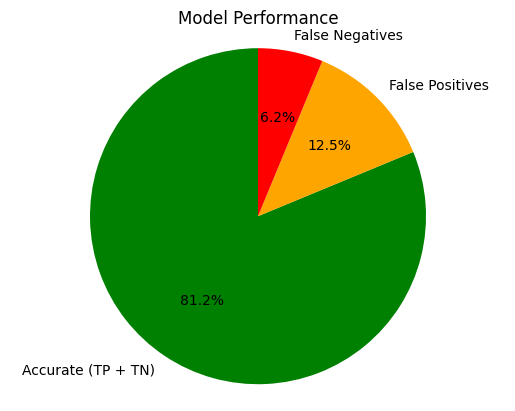

In [2]:
# Load the model and plot a pie chart with accuracte values, false positives and false negatives
import pickle
import numpy as np
import matplotlib.pyplot as plt



clf = pickle.load(open('svm_model.pkl', 'rb'))

# # Load the saved model
# with open('svm_model.pkl', 'rb') as f:
#     clf = pickle.load(f)

# Load the saved predictions and true labels
y_pred = np.load('predictions.npy')
y_test = np.load('y_test.npy')
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract values from confusion matrix
true_positives = cm[1, 1]
true_negatives = cm[0, 0]
false_positives = cm[0, 1]
false_negatives = cm[1, 0]

# Calculate accuracy
accuracy = (true_positives + true_negatives) / len(y_test)
# Data for the pie chart
labels = ['Accurate (TP + TN)', 'False Positives', 'False Negatives']
sizes = [accuracy, false_positives / len(y_test), false_negatives / len(y_test)]
colors = ['green', 'orange', 'red']


# Create pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Model Performance')
plt.show()



Accuracy on test set: 0.8125
Confusion Matrix:
 [[10  2]
 [ 1  3]]
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        12
           1       0.60      0.75      0.67         4

    accuracy                           0.81        16
   macro avg       0.75      0.79      0.77        16
weighted avg       0.83      0.81      0.82        16



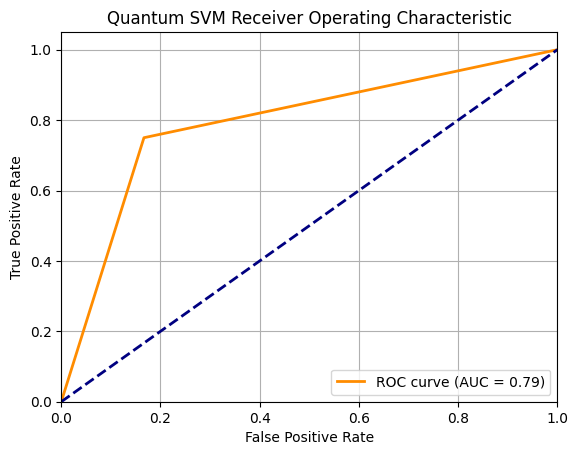

In [9]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import DiagonalGate, Initialize
from qiskit.quantum_info import Statevector
from qiskit.circuit import QuantumRegister, QuantumCircuit
num_qubits = 2  # 2^2 = 4 amplitudes
def feature_map_circuit(x):
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)

    # Amplitude embedding
    qc.append(Initialize(x), qr)

    # Phase encoding via DiagonalGate
    phases = [xi % (2 * np.pi) for xi in x]
    diag = [np.cos(p) + 1j * np.sin(p) for p in phases]
    qc.append(DiagonalGate(diag), qr)

    return transpile(qc, basis_gates=['u3', 'cx'])

def quantum_kernel(x1, x2):
    sv1 = Statevector.from_instruction(feature_map_circuit(x1))
    sv2 = Statevector.from_instruction(feature_map_circuit(x2))
    return np.abs(np.dot(np.conjugate(sv1.data), sv2.data))**2

def build_kernel_matrix(A, B):
    return np.array([[quantum_kernel(a, b) for b in B] for a in A])
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_pred = np.load('predictions.npy')
y_test = np.load('y_test.npy')

# K_test = build_kernel_matrix(X_test, X_train)
# y_pred = clf.predict(K_test)

print("Accuracy on test set:", accuracy_score(y_test, y_pred))
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print(classification_report(y_test, y_pred))
y_score = clf.decision_function(K_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Quantum SVM Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

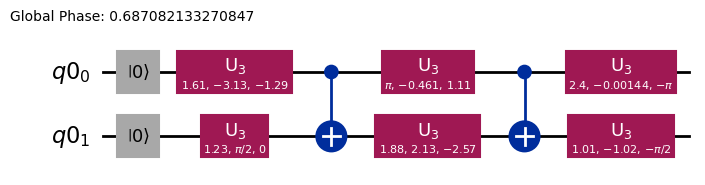

In [ ]:
!pip install -q pylatexenc
import pickle
import numpy as np
from qiskit.visualization import circuit_drawer

# Load the saved model
with open('svm_model.pkl', 'rb') as f:
    clf = pickle.load(f)

# Load the metadata (optional, for information)
with open('metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

# Load the training data (for creating the circuit)
X_train = np.load('X_train.npy') # Assuming you have saved your X_train data

# Assuming feature_map_circuit is already defined in the previous cells.
# If not, you'll need to redefine it.
def feature_map_circuit(x):
    from qiskit import QuantumRegister, QuantumCircuit, transpile
    from qiskit.circuit.library import DiagonalGate, Initialize
    num_qubits = 2  # 2^2 = 4 amplitudes

    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)

    # Amplitude embedding
    qc.append(Initialize(x), qr)

    # Phase encoding via DiagonalGate
    phases = [xi % (2 * np.pi) for xi in x]
    diag = [np.cos(p) + 1j * np.sin(p) for p in phases]
    qc.append(DiagonalGate(diag), qr)

    return transpile(qc, basis_gates=['u3', 'cx'])


# Choose a data point to visualize the circuit for (e.g., the first one)
circuit = feature_map_circuit(X_train[0])

# Draw the circuit using Matplotlib
circuit_drawer(circuit, output='mpl')

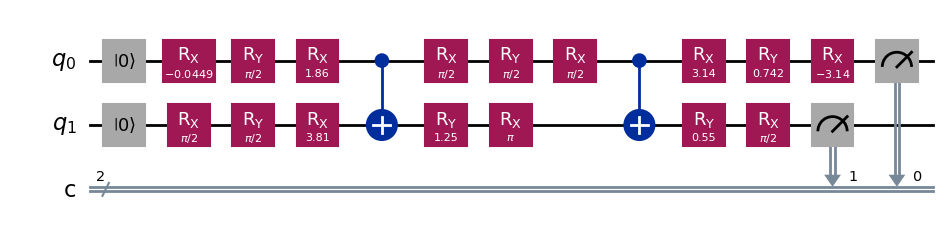

In [ ]:
import pickle
import numpy as np
from qiskit.visualization import circuit_drawer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.circuit.library import DiagonalGate, Initialize
def feature_map_circuit_with_classical_bits(x):
    num_qubits = 2
    qr = QuantumRegister(num_qubits, name="q")  # Rename quantum register to "q"
    cr = ClassicalRegister(num_qubits, name="c")  # Rename classical register to "c"
    qc = QuantumCircuit(qr, cr)

    qc.append(Initialize(x), qr)

    phases = [xi % (2 * np.pi) for xi in x]
    diag = [np.cos(p) + 1j * np.sin(p) for p in phases]
    qc.append(DiagonalGate(diag), qr)

    qc.measure(qr, cr)  # Add measurements

    return transpile(qc, basis_gates=['id', 'ry', 'rx', 'cx'])  # Return the non-transpiled circuit


# ... (load model and data)

# Draw the non-transpiled circuit with classical bits and measurements:
circuit = feature_map_circuit_with_classical_bits(X_train[0])
circuit_copy = circuit.copy()
circuit_copy.global_phase = 0
circuit_copy.draw('mpl', filename='non_transpiled_circuit.png')